In [1]:
## Environment: conda env:tf212gpu
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/reanalysis/'

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir)
from utils import split_obs, plot_results
from exp_hp import get_hp

2025-01-31 11:52:09.960128: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-31 11:52:11.450696: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


### Fuctions

In [3]:
# ---------------- LEARNING RATE CALLBACK FUNCTION ----------------
def scheduler(epoch, lr):
    # This function keeps the initial learning rate for the first ten epochs
    # and decreases it exponentially after that.
    if epoch < 10:
        return lr
    else:
        return lr * tf.constant(.5,dtype=tf.float32)

In [4]:
def create_ann2(input_shape,output_shape, hiddens, RIDGE = 0, dropout = True, dropout_rate = 0.0):
    tf.keras.backend.clear_session() 

    # ----- input of cnn -----
    ann_input = keras.Input(shape = input_shape)

    for l,layer in enumerate(hiddens):
        # ----- ann layers -----
        if l == 0:
            x = tf.keras.layers.Dense(layer, 
                                      activation = 'relu',
                                      use_bias = True, 
                                      kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=RIDGE),
                                      bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                      kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(ann_input)
            if dropout:
                x = layers.Dropout(rate = dropout_rate)(x)
        else:
            x = tf.keras.layers.Dense(layer, 
                                      activation = 'relu',
                                      use_bias = True, 
                                      kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                      bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                      kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(x)
        
    # ----- output -----
    ann_output = tf.keras.layers.Dense(output_shape,
                                       activation = tf.keras.activations.softmax,
                                       use_bias = True,
                                       kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                       bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                       kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(x)
    # ----- create unet -----
    ann = keras.Model(ann_input, ann_output, name = 'ann')
    
    return ann

In [5]:
EXP_NAME2 = 'exp2_retrain.1'
hps2 = get_hp(EXP_NAME2)
EXP_NAME = 'exp2'
hps = get_hp(EXP_NAME)

print('Training Years: '+str(hps2['train_yrs']))
print('Validation Years: '+str(hps2['val_yrs']))
print('Testing Years: '+str(hps2['test_yrs']))
print('Lead: '+str(hps2['LEAD']))
print('Region: '+str(hps2['region'][0])+'N x '+str(hps2['region'][1])+'E')

X2train, X2val, _, Y2train, Y2val, _ = split_obs(trainyrs=hps2['train_yrs'],
                                                    valyrs=hps2['val_yrs'],
                                                    testyrs=hps2['test_yrs'],
                                                    months=[11,12,1,2],
                                                    lead=hps2['LEAD'],
                                                    latpt = hps2['region'][0],
                                                    lonpt = hps2['region'][1]) # 330 or 210

X2val = X2val.reshape((X2val.shape[0],X2val.shape[1]*X2val.shape[2]))
X2train = X2train.reshape((X2train.shape[0],X2train.shape[1]*X2train.shape[2]))
input_shape = X2train.shape[1]

Training Years: [1999, 2018]
Validation Years: [2018, 2023]
Testing Years: [1996, 1999]
Lead: 14
Region: [30, 60]N x [170, 240]E


In [67]:
# ---------- ANN Hyperparameters ----------
NLABEL = 2
N_EPOCHS = 100
GLOBAL_SEED = hps['GLOBAL_SEED']
HIDDENS = hps2['HIDDENS']
ann2LR_INIT = hps2['LR_INIT'] 
ann2BATCH_SIZE = hps2['BATCH_SIZE'] 
ann2dropout_rate = hps2['DROPOUT_RATE'] 
dropout_bool = True
ann2RIDGE = #hps2['RIDGE'] 
PATIENCE = hps2['PATIENCE']

print(HIDDENS, ann2LR_INIT, ann2BATCH_SIZE, ann2dropout_rate, ann2RIDGE, PATIENCE)

[128] 0.001 64 0.95 3.0 10


0
Elapsed time during fit = 3.04 seconds



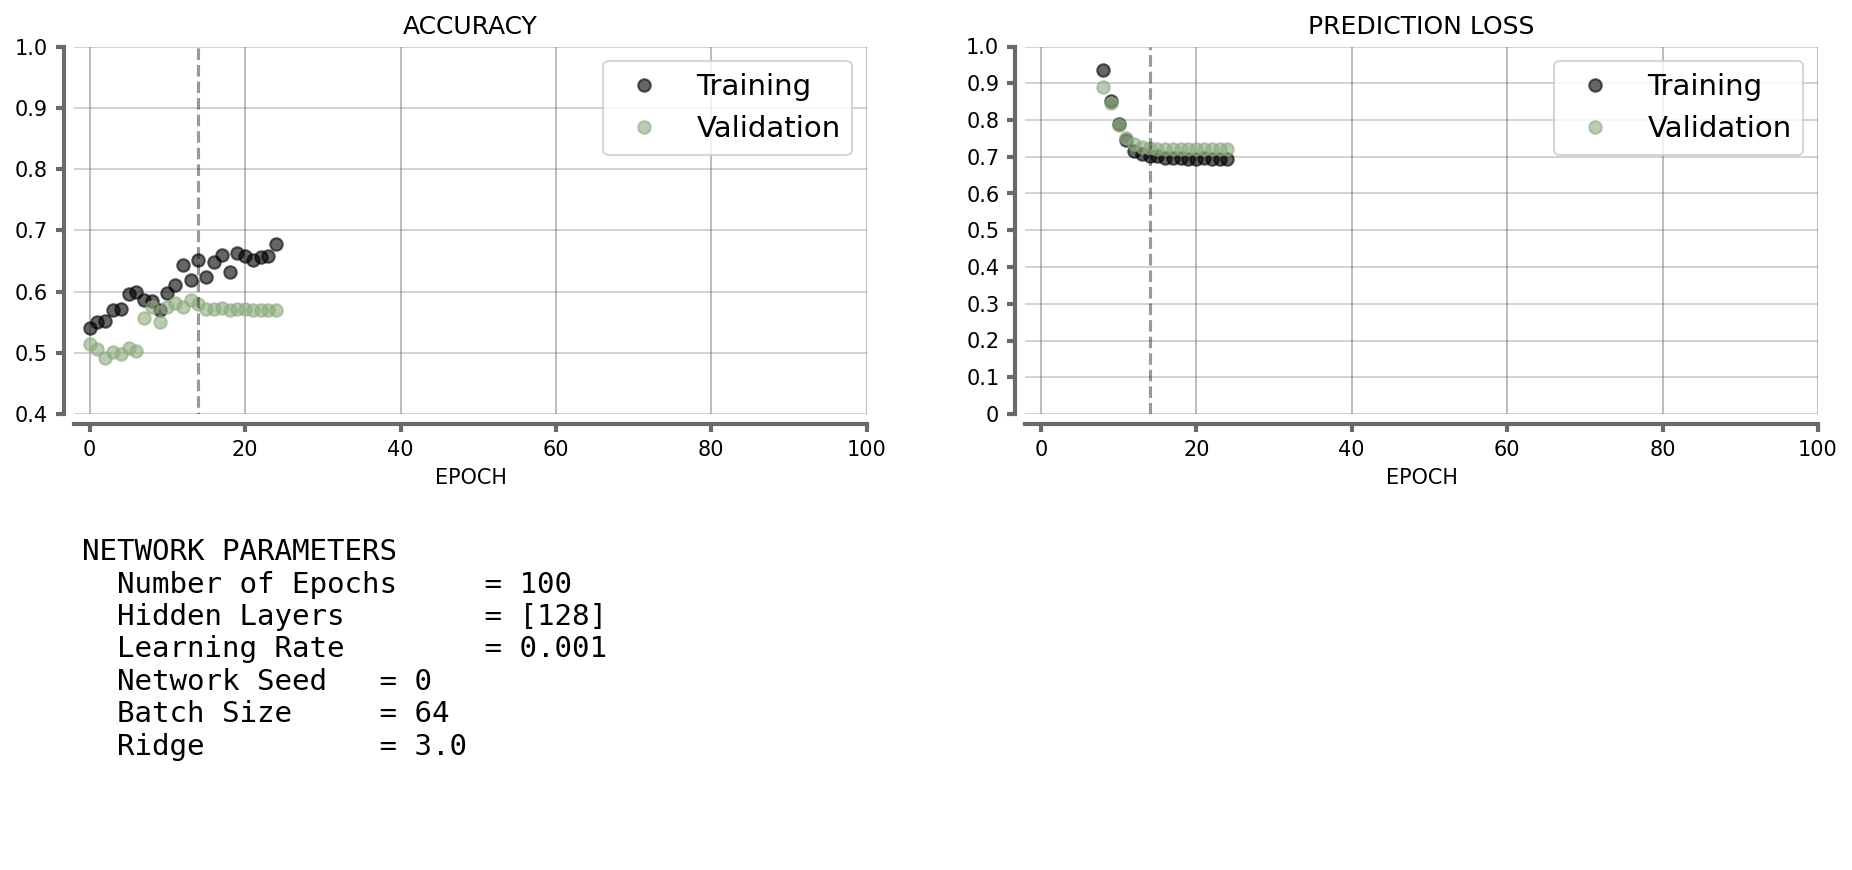

18/18 [==============================] - 0s 861us/step
50.88652482269504
57.97872340425532
1
Elapsed time during fit = 2.93 seconds



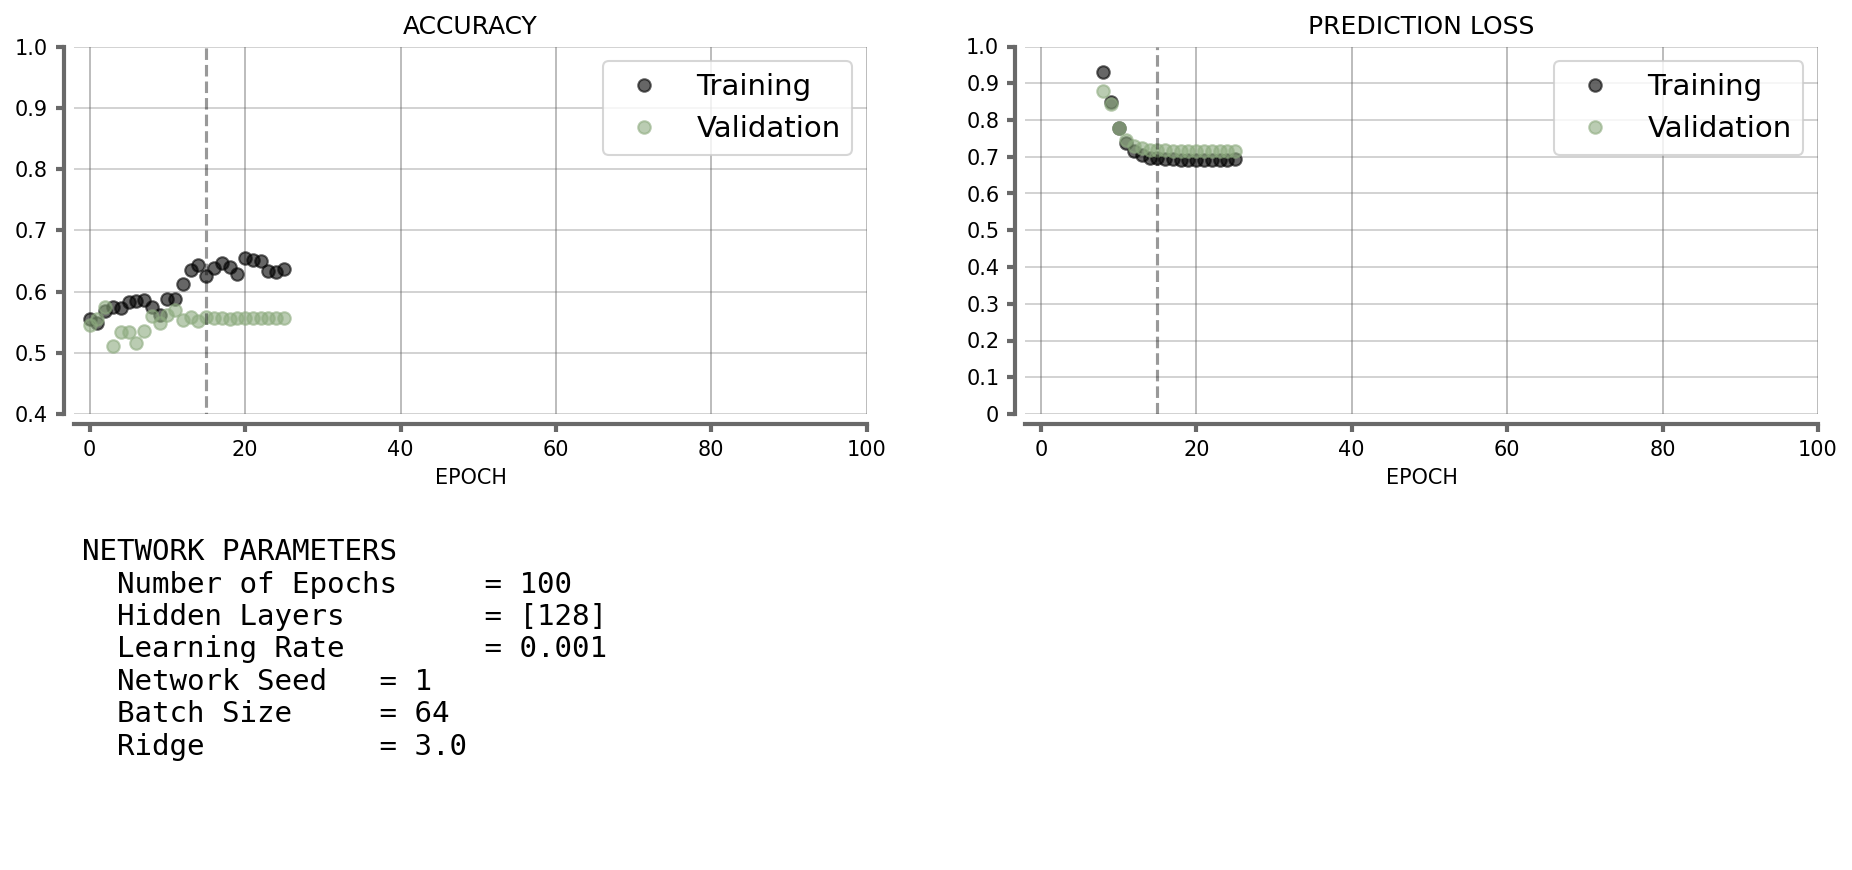

2
Elapsed time during fit = 2.89 seconds



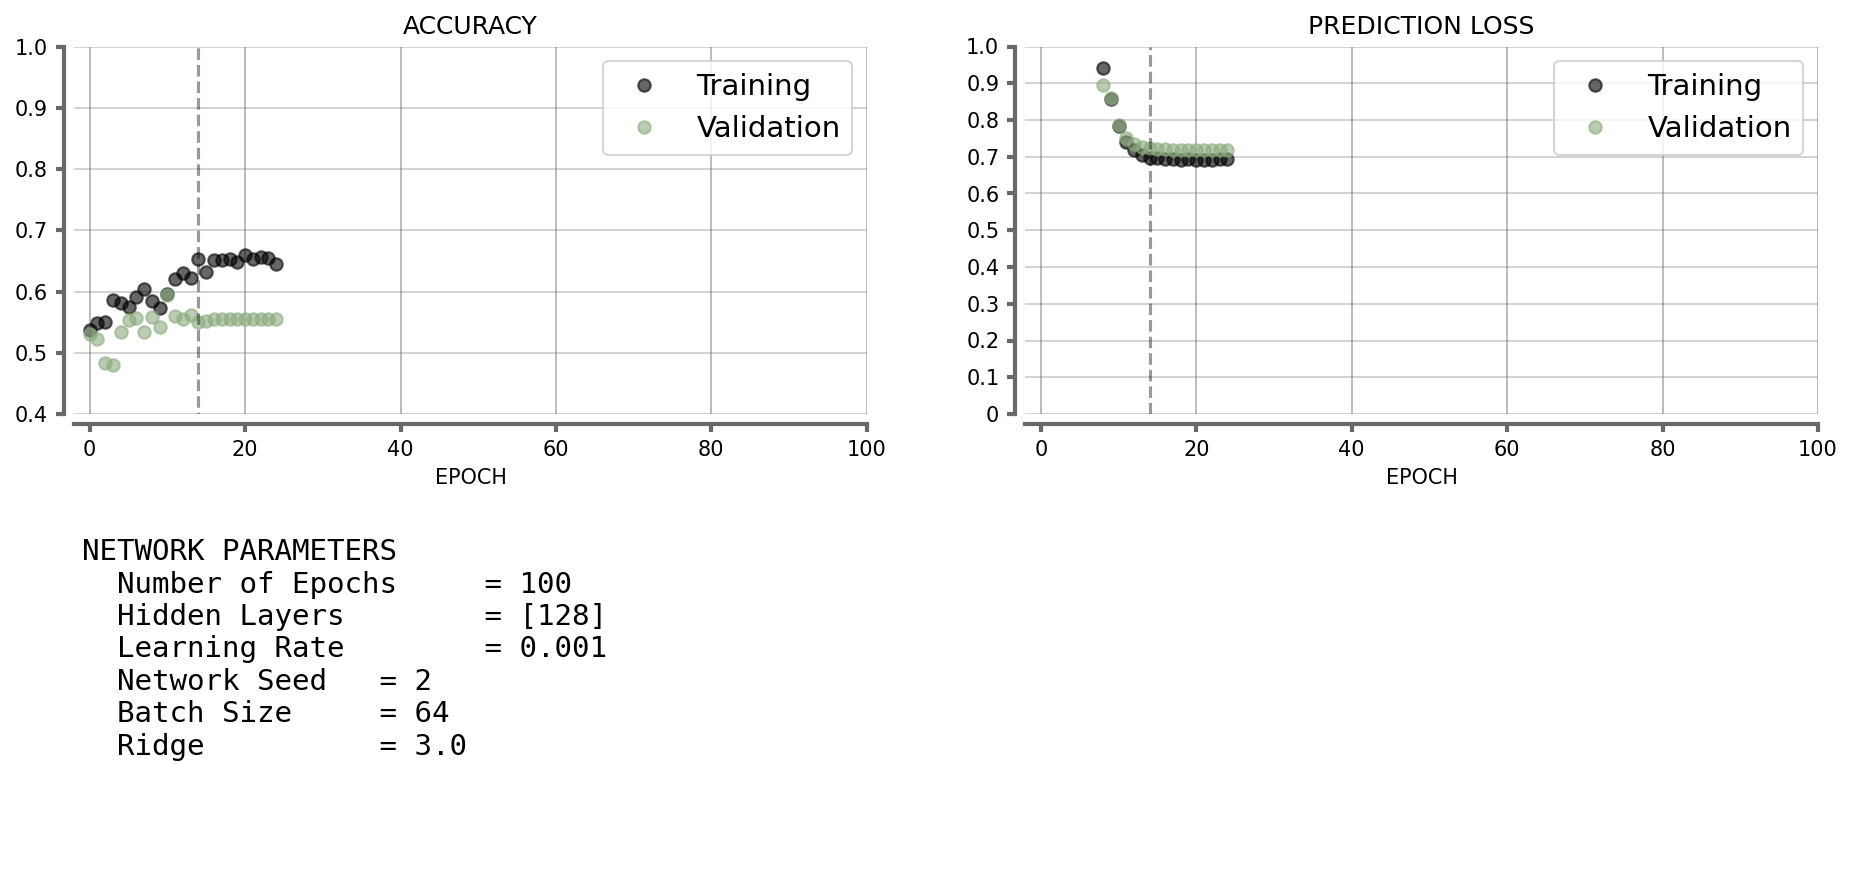

3
Elapsed time during fit = 2.82 seconds



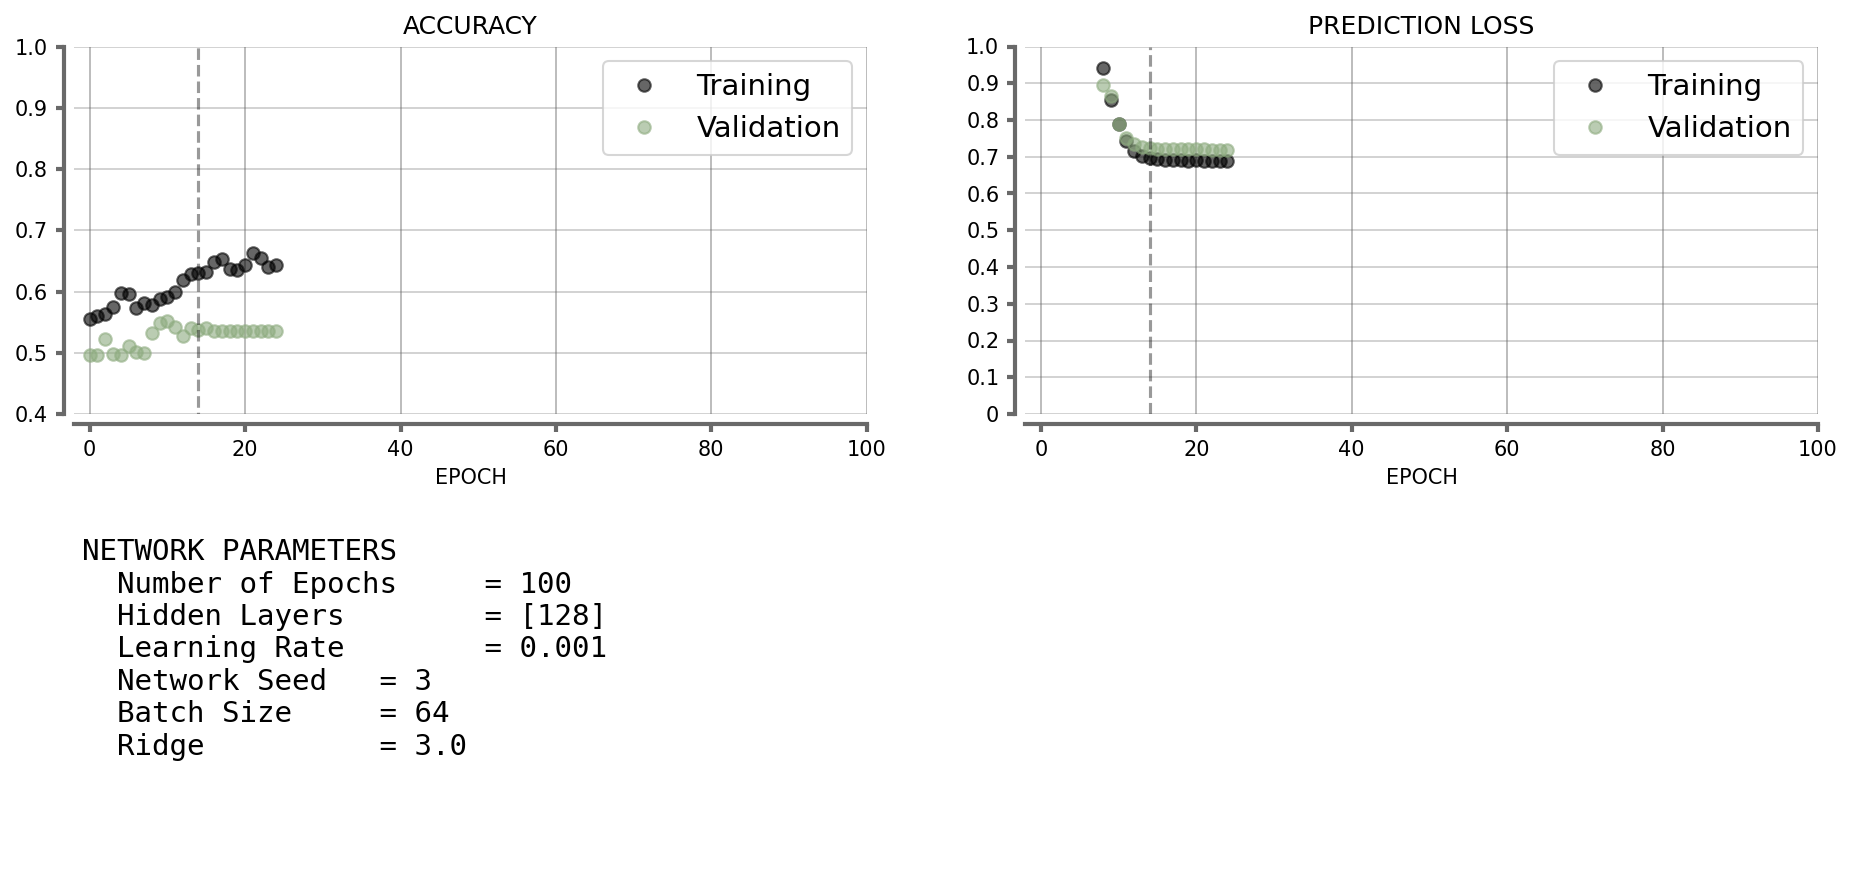

4
Elapsed time during fit = 3.24 seconds



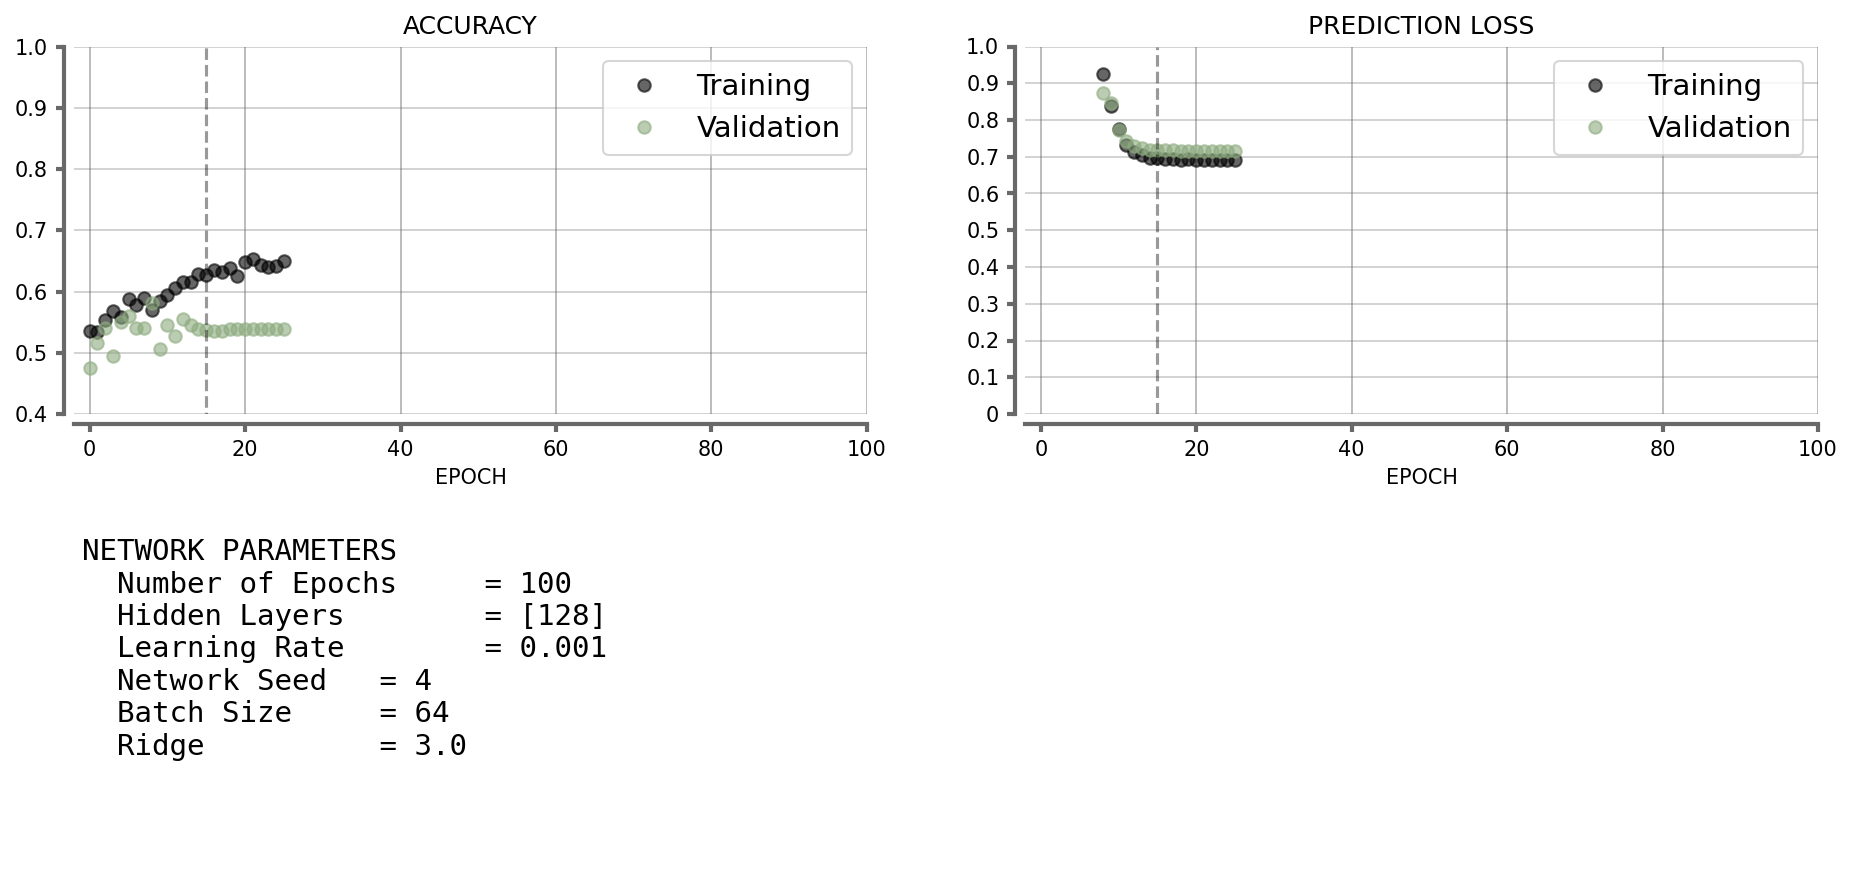

5
Elapsed time during fit = 3.08 seconds



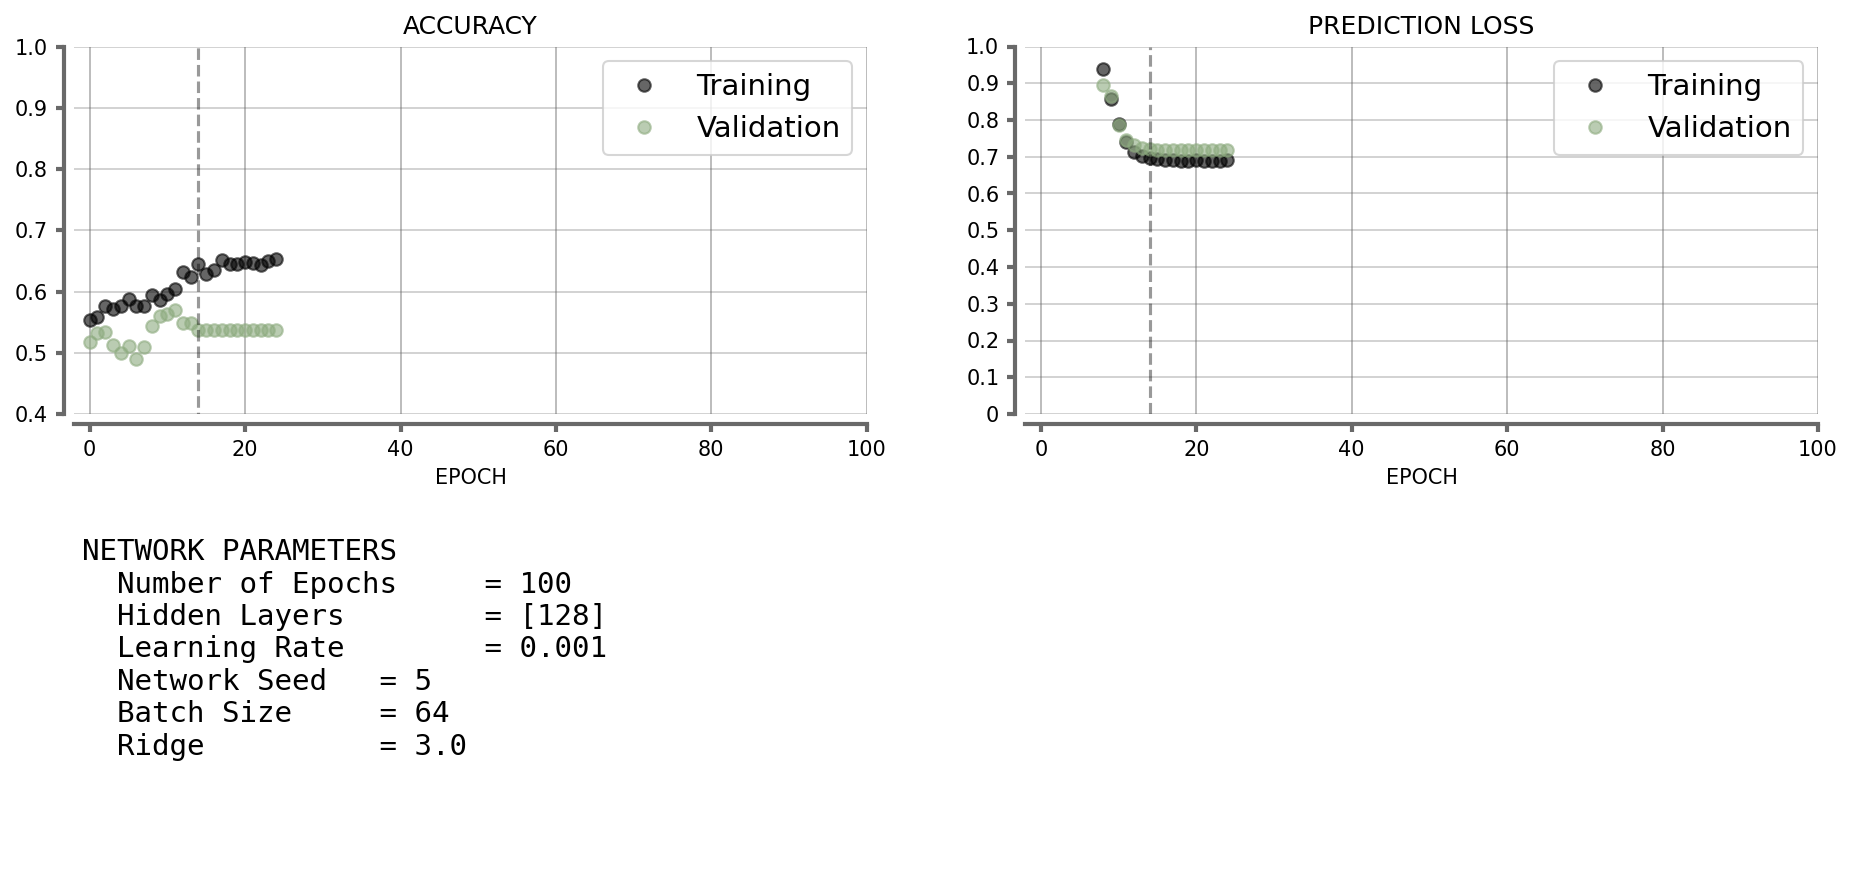

6
Elapsed time during fit = 3.14 seconds



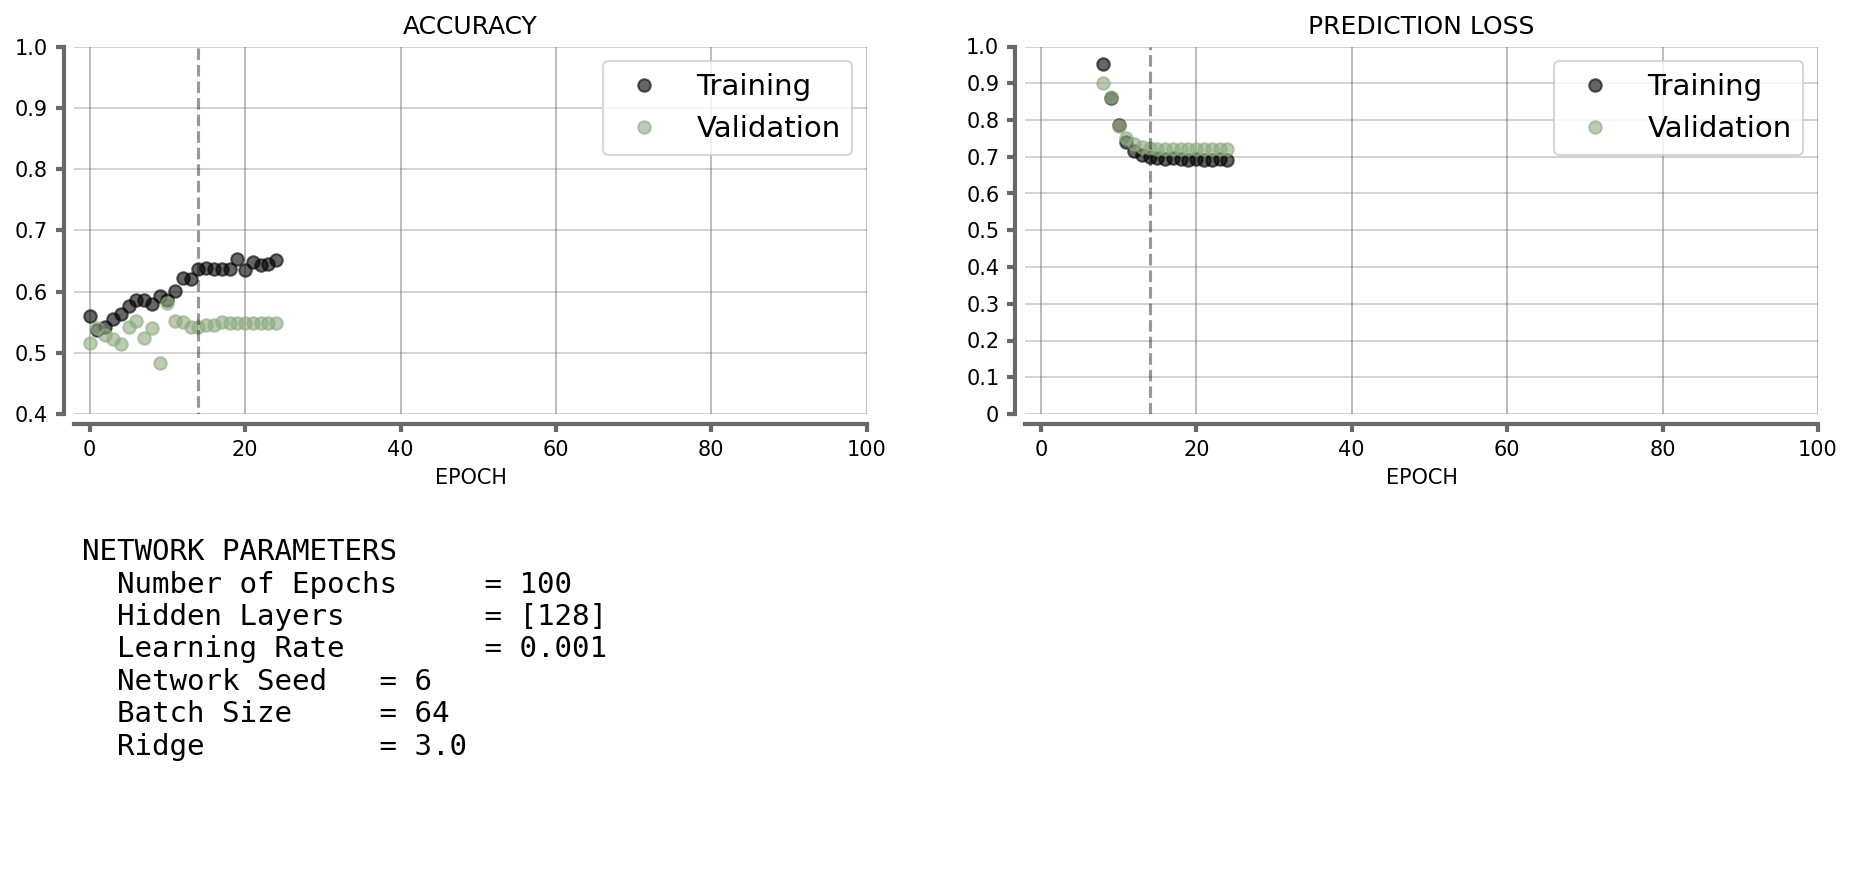

7
Elapsed time during fit = 3.07 seconds



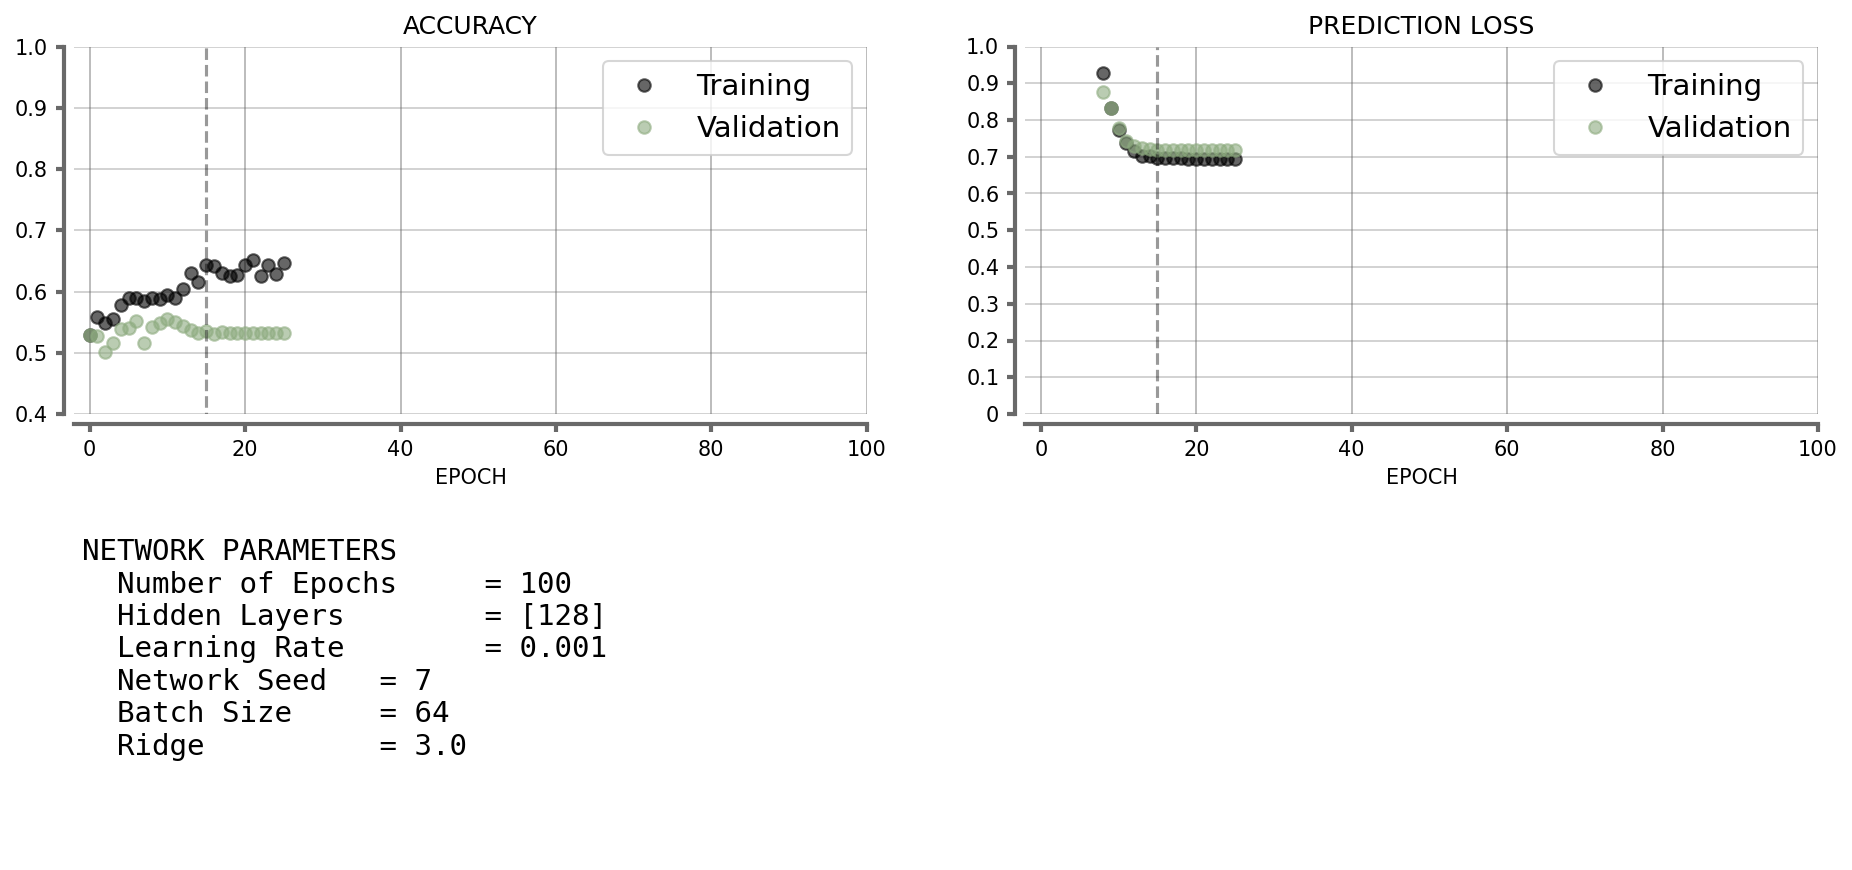

8
Elapsed time during fit = 2.95 seconds



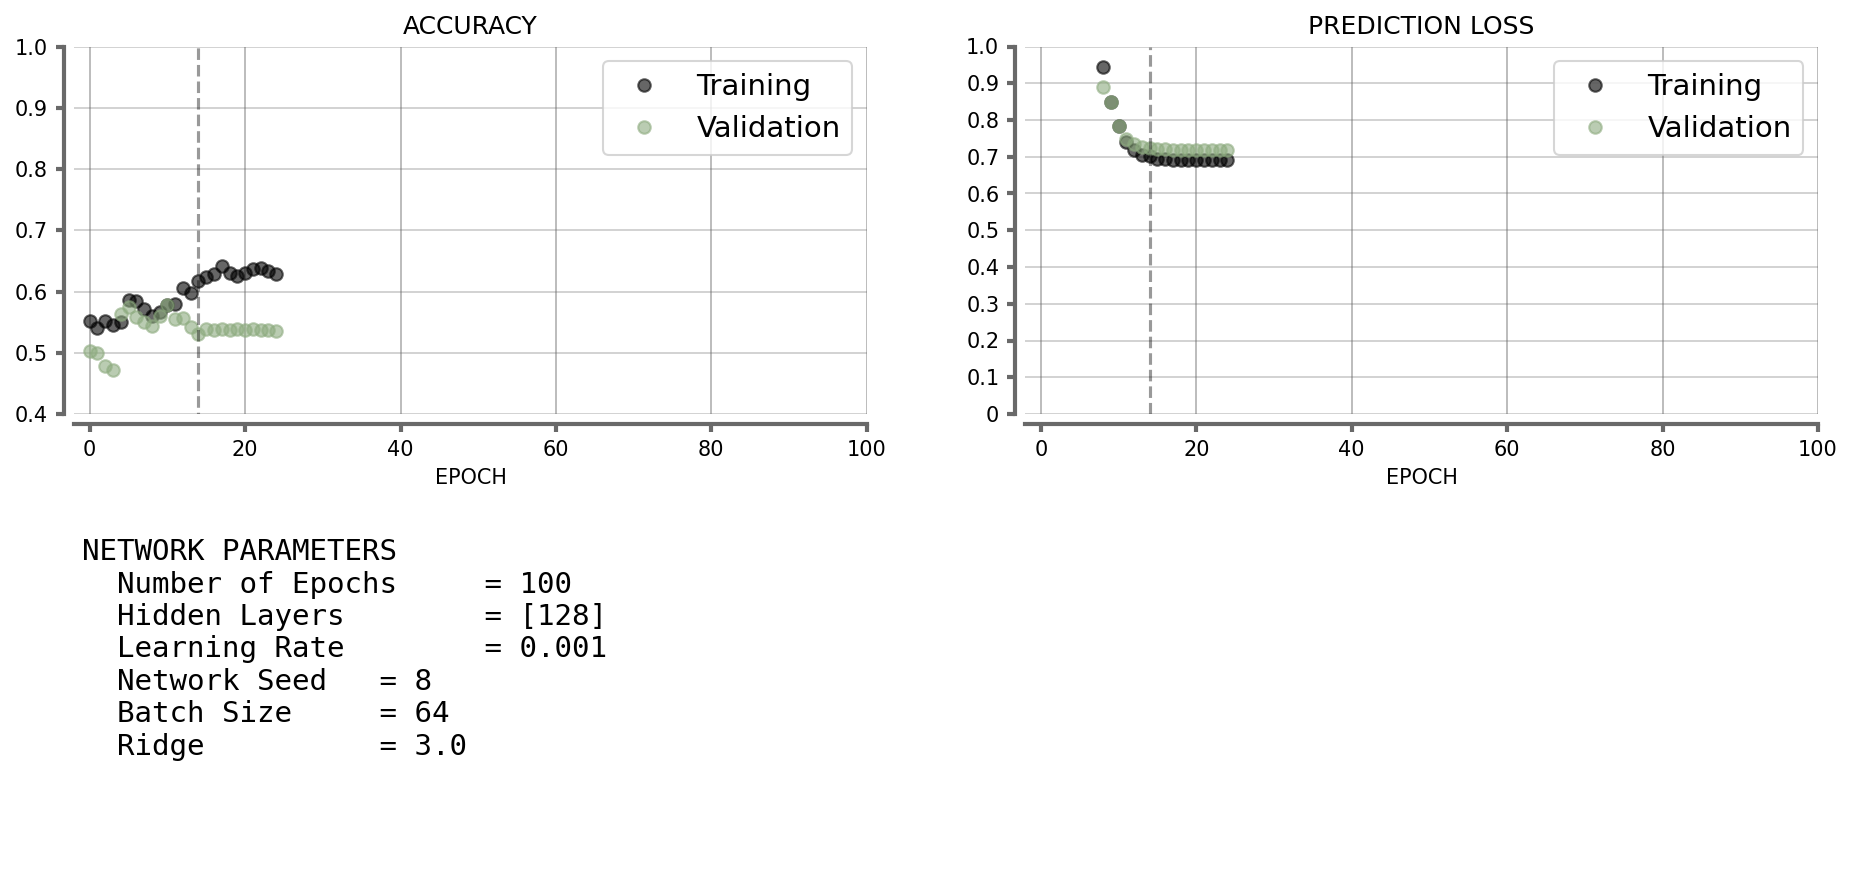

9
Elapsed time during fit = 3.10 seconds



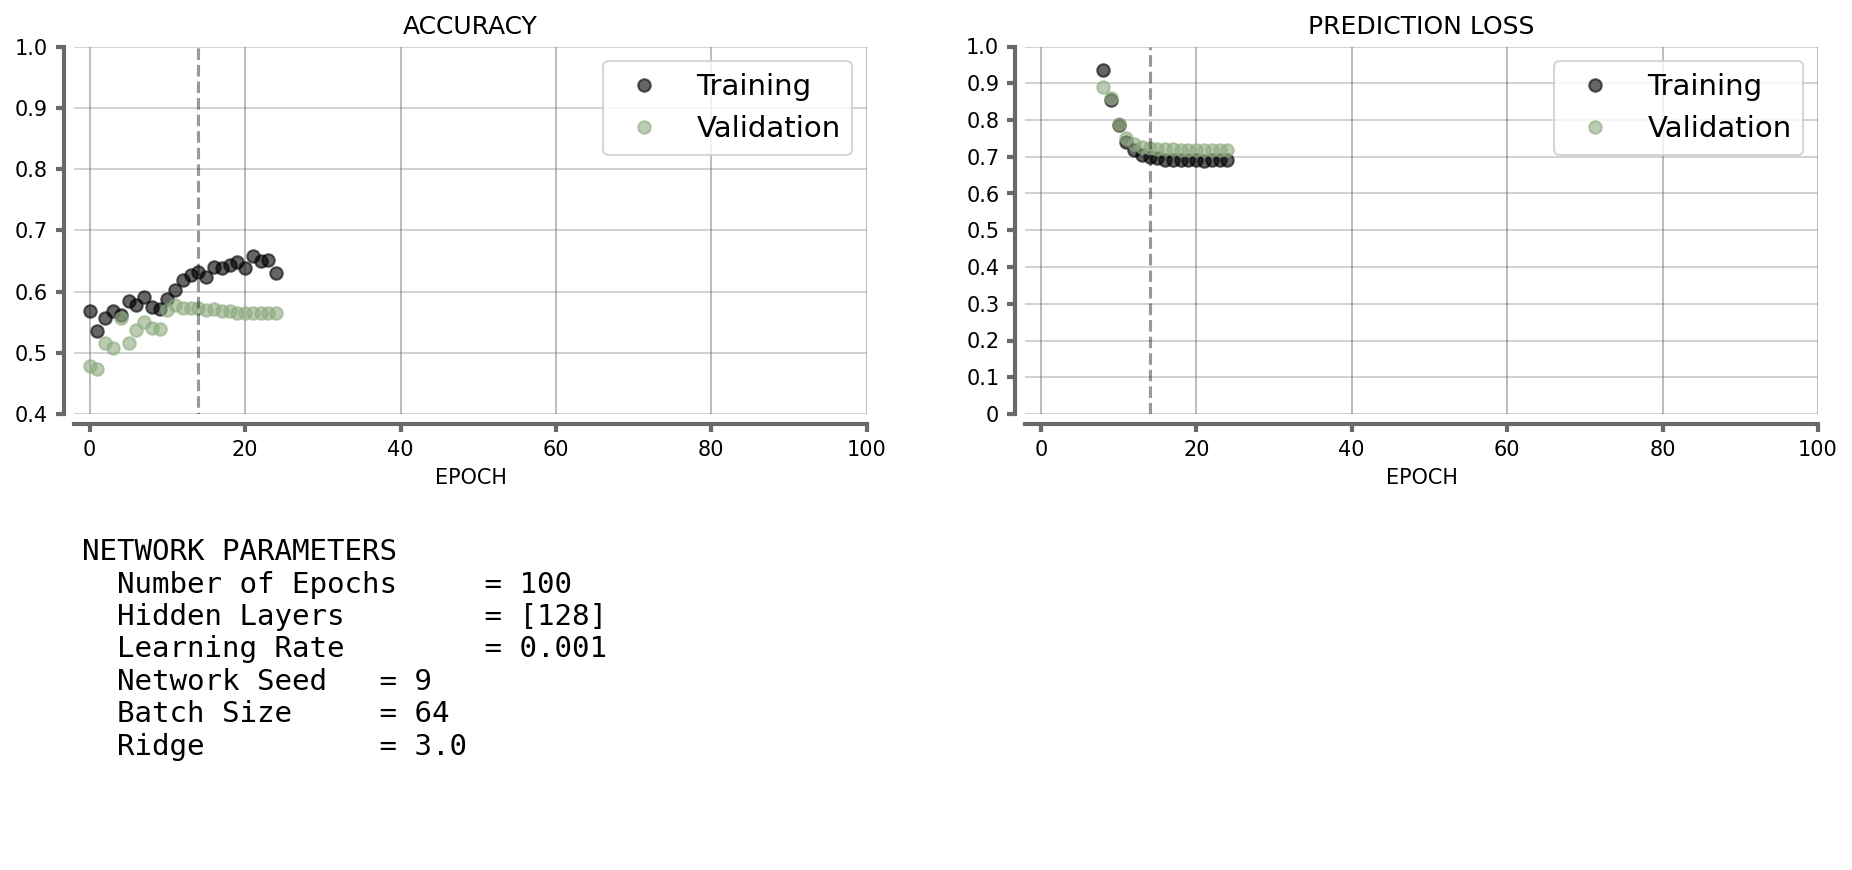

CPU times: user 30.3 s, sys: 1.59 s, total: 31.9 s
Wall time: 51.3 s


In [68]:
%%time
#----- SET UP & TRAIN NN -----
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

for SEED in range(10):
    print(SEED)
    tf.keras.backend.clear_session() 

    # ------ define NN ------
    ann2 = create_ann2(input_shape = input_shape,
                       output_shape = NLABEL,
                       hiddens=HIDDENS,
                       RIDGE = ann2RIDGE,
                       dropout = dropout_bool, dropout_rate = ann2dropout_rate)

    annfi_name = 'ann1_e3sm_'+EXP_NAME+'_seed'+str(SEED)+'.h5'
    ann1 = tf.keras.models.load_model(base_dir+'train/saved_models/'+annfi_name)
    ann2.layers[1].set_weights(ann1.layers[1].get_weights())
    # ann2.summary()

    # ------ Training Hyperparameters ------
    optimizer = tf.optimizers.Adam(learning_rate = ann2LR_INIT,)
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy", dtype=None)]                             

    # ------ Compile Model -----
    ann2.compile(optimizer = optimizer,
                loss = loss_func,
                metrics = metrics)

    # ----- Callbacks -----
    ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'auto', min_delta = 0.01,
                                          patience = PATIENCE, verbose = 0, restore_best_weights = True)
    LR = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0)

    # ------ Train -----
    start_time = time.time()
    history = ann2.fit(X2train,Y2train,
                      validation_data = [X2val,Y2val],
                      batch_size = ann2BATCH_SIZE,
                      epochs = N_EPOCHS,
                      shuffle = True,
                      verbose = 0,
                      callbacks = [ES,LR])
    stop_time = time.time()
    tf.print(f"Elapsed time during fit = {(stop_time - start_time):.2f} seconds\n")

    #----- PLOT THE RESULTS -----
    plot_results(
        history,
        exp_info=(100, HIDDENS, ann2LR_INIT, ann2BATCH_SIZE, SEED, PATIENCE, ann2RIDGE),
        showplot=True
    ) 

    annfi_name = 'ann2_obs_'+EXP_NAME2+'_ann1-'+EXP_NAME+'_seed'+str(SEED)+'.h5'
    ann2.save(base_dir+'train/saved_models/'+annfi_name)
    
    if SEED == 0:
        pred1 = np.argmax(ann1.predict(X2val),axis=-1)
        pred2 = np.argmax(ann2.predict(X2val),axis=-1)

        print((np.shape(np.where(pred1==Y2val)[0])[0]/np.shape(Y2val)[0])*100) # og network 
        print((np.shape(np.where(pred2==Y2val)[0])[0]/np.shape(Y2val)[0])*100) # first layer weights transferred 